In [340]:
%matplotlib inline

In [366]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import ruptures as rpt
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings("ignore")

## Load the data

In [342]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas",
                      trim_start=trim_start, trim_end=trim_end,
                      api_key= "XXXXXXXXXX")
    return qdata

In [343]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

### Get the future prices for two pairs: CBT_FV_FV (W), CBT_US_US (X); CBT_FV_FV (Y), CBT_TY_TY (Z)

In [344]:
def get_future_prices(name, year, quarter):
    future_prices = []
    for y in year:
        for q in quarter:
            data = clean_quandl_columns(fetch_quandl(('OWF/'+name+'_'+q+y+'_IVM',),
                                         trim_start="2019-12-03",
                                         trim_end="2021-08-31"))
            data = data[['Future', 'DtT']]            
            future_prices.append(data)
    future_prices_frame = pd.concat(future_prices)
    future_prices_frame.loc[future_prices_frame['DtT'] > 30]
    future_prices_frame = future_prices_frame.sort_values(by = ['Date', 'DtT'], ascending = [True, True])
    future_prices_frame = future_prices_frame[~future_prices_frame.index.duplicated(keep='first')]
    return future_prices_frame

#### Get future price of CBT_FV_FV (CBT 5-Year US T-Notes)

In [346]:
FV_price = get_future_prices(name = 'CBT_FV_FV', year = ['2020','2021'], quarter=['H','M','U','Z'])
FV_price.head(5)

,Future,DtT
Date,,
2019-12-03,119.367188,119.0
2019-12-04,118.992188,118.0
2019-12-05,118.921875,117.0
2019-12-06,118.664062,116.0
2019-12-09,118.679688,113.0


#### Get future price of CBT_US_US (CBT 30-Year US T-Bonds)

In [347]:
US_price = get_future_prices(name = 'CBT_US_US', year = ['2020','2021'], quarter=['H','M','U','Z'])
US_price.head(5)

,Future,DtT
Date,,
2019-12-03,160.09375,108.0
2019-12-04,158.71875,107.0
2019-12-05,158.34375,106.0
2019-12-06,157.62500,105.0
2019-12-09,157.96875,102.0


#### Get future price of CBT_TY_TY (CBT 10-Year US T-Notes)

In [348]:
TY_price = get_future_prices(name = 'CBT_TY_TY', year = ['2020','2021'], quarter=['H','M','U','Z'])
TY_price.head(5)

,Future,DtT
Date,,
2019-12-03,130.031250,108.0
2019-12-04,129.421875,107.0
2019-12-05,129.312500,106.0
2019-12-06,128.890625,105.0
2019-12-09,128.968750,102.0


### Calculate spreads s1 & s2 and check the value

In [354]:
s1 = US_price['Future'] - FV_price['Future']
s2 = TY_price['Future'] - FV_price['Future']

In [355]:
s1.loc['2021-02-18'].round(6) == 39.023438

True

In [356]:
s1.loc['2021-02-19'].round(6) == 36.593750

True

In [357]:
s2.loc['2021-02-18'].round(6) == 10.382812

True

In [358]:
s2.loc['2021-02-19'].round(6) == 9.375000

True

## Analysis

In [359]:
def get_basic_statistics(df):
    table = pd.DataFrame(columns = df.columns)
    table.loc['lower quartile'] = df.quantile(.25)
    table.loc['Median'] = df.median()
    table.loc['upper quartile'] = df.quantile(.75)
    table.loc['standard deviation'] = df.std()
    table.loc['skewness'] = df.skew()
    table.loc['kurtosis'] = df.kurt()
    return table

In [360]:
def standardize_data(df):
    return (df-df.mean())/df.std()

In [456]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    timeseries.rolling(5).mean()
    rolmean = timeseries.rolling(5).mean()
    rolstd = timeseries.rolling(5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## 1. Futures

In [362]:
futures = pd.concat([FV_price['Future'], US_price['Future'], TY_price['Future']], axis=1)
futures.columns = ['CBT_FV_FV', 'CBT_US_US', 'CBT_TY_TY']

### Plots

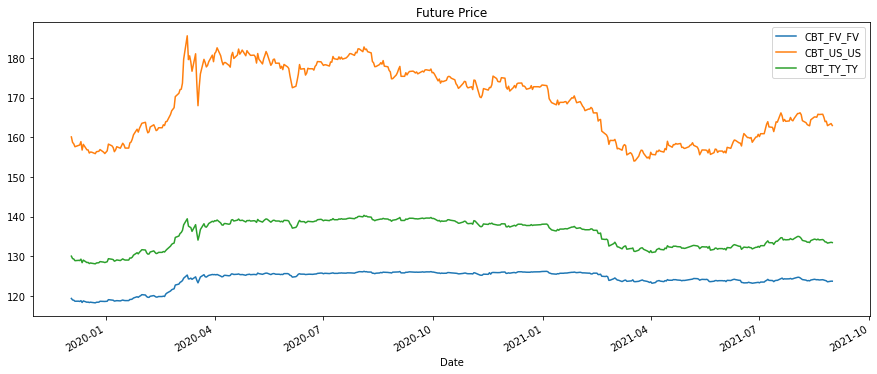

In [364]:
futures.plot(title="Future Price")
plt.show()

Although the prices of three futures are very different, the changes of prices seem to be similar. During January 2020 to March 2020 and March 2021 to October 2021, all three futures have relatively low prices. In my opinion, the lower prices are mainly due to the effect of pandemic.

### Basic Statistics

In [371]:
get_basic_statistics(futures)

,CBT_FV_FV,CBT_US_US,CBT_TY_TY
lower quartile,123.828125,159.312500,132.328125
Median,125.179688,169.375000,136.859375
upper quartile,125.757812,176.937500,138.859375
standard deviation,2.143907,8.879366,3.524776
skewness,-1.592018,-0.068982,-0.428078
kurtosis,1.505298,-1.477159,-1.220305


In [372]:
get_basic_statistics(standardize_data(futures))

,CBT_FV_FV,CBT_US_US,CBT_TY_TY
lower quartile,-0.195733,-1.051522,-0.909832
Median,0.434688,0.081723,0.375711
upper quartile,0.704347,0.933417,0.943123
standard deviation,1.000000,1.000000,1.000000
skewness,-1.592018,-0.068982,-0.428078
kurtosis,1.505298,-1.477159,-1.220305


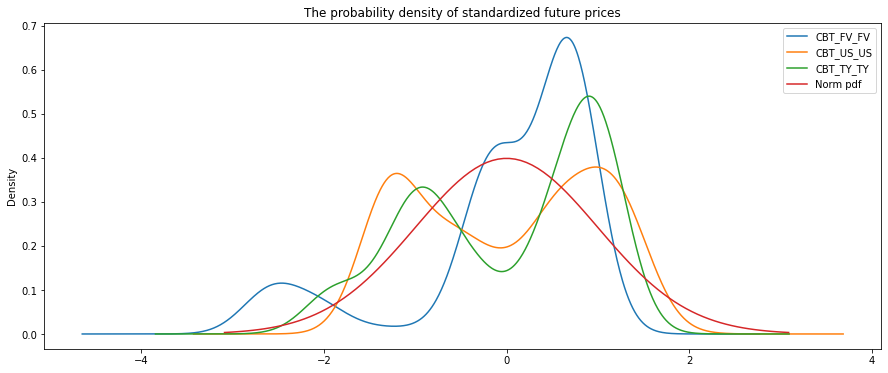

In [396]:
standardize_data(futures).plot.kde()
pdf = norm.pdf(0)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
plt.plot(x, norm.pdf(x),label='Norm pdf')
plt.legend()
plt.title('The probability density of standardized future prices')
plt.show()

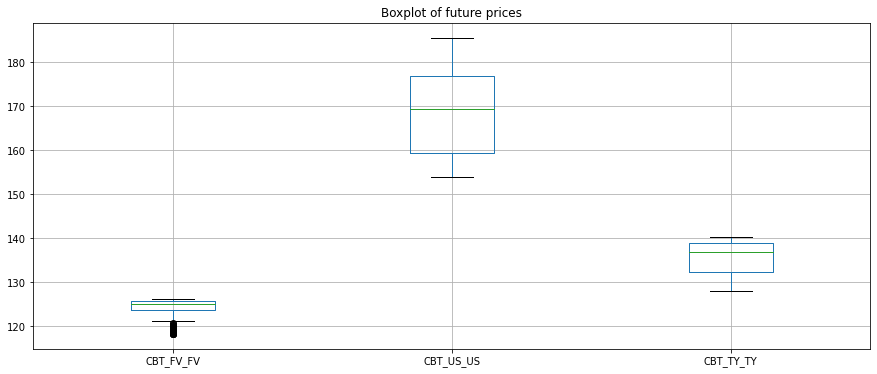

In [402]:
boxplot = futures.boxplot()
plt.title('Boxplot of future prices')
plt.show()

According to the original and standardized future prices, CBT_US_US has the highest average value and standard deviation, while CBT_FV_FV has the lowest average value and standard deviation. Also, although all three future prices are negative skewed, the plot of CBT_US_US is most symmetrical, since its skewness is very close to 0. Also, the plots of all three futures are platykurtic, so they will have thinner tails and lower peaks comparing with normal distribution. In particular, CBT_US_US will have least extreme values since it has the lowest kurtosis.

In [210]:
futures.corr()

,CBT_FV_FV,CBT_US_US,CBT_TY_TY
CBT_FV_FV,1.000000,0.660920,0.867885
CBT_US_US,0.660920,1.000000,0.935209
CBT_TY_TY,0.867885,0.935209,1.000000


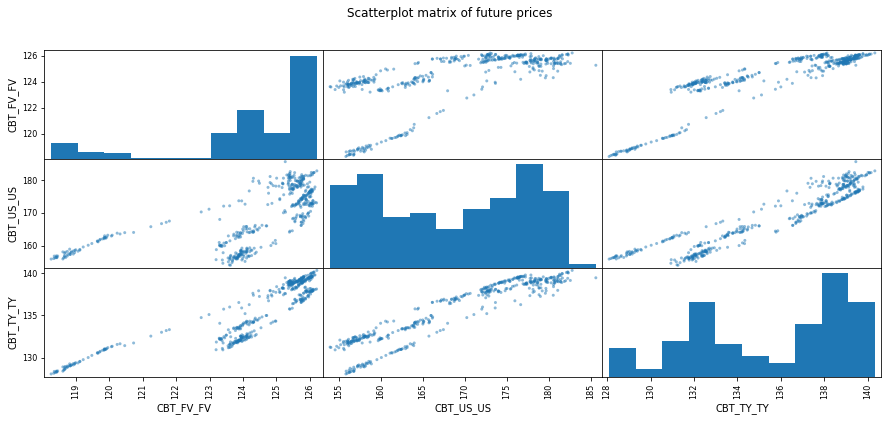

In [400]:
pd.plotting.scatter_matrix(futures)
plt.suptitle('Scatterplot matrix of future prices')
plt.show()

The price of first pair CBT_FV_FV (W) and CBT_US_US (X) has strong positive correlation, and the price of second pair CBT_FV_FV (Y) and CBT_TY_TY (Z) has very high positive correlation.

## 2. Spreads

In [403]:
spreads = pd.concat([s1, s2], axis=1)
spreads.columns = ['s1', 's2']

### Plot

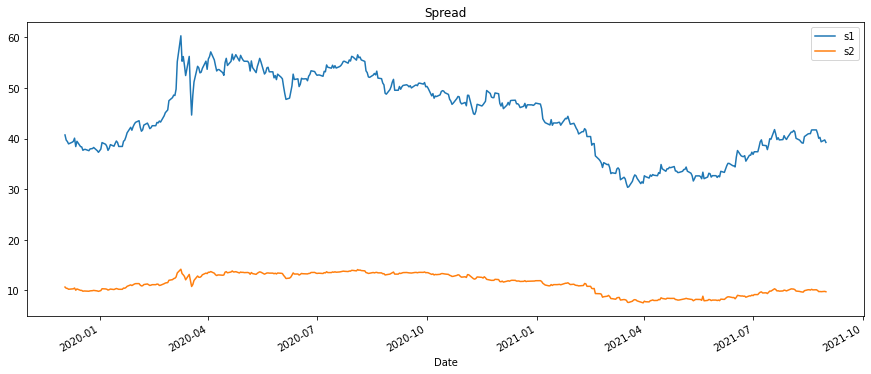

In [404]:
spreads.plot(title="Spread")
plt.show()

### Basic statistics

In [405]:
get_basic_statistics(spreads)

,s1,s2
lower quartile,38.429688,9.812500
Median,44.414062,11.414062
upper quartile,51.085938,13.281250
standard deviation,7.633887,1.975734
skewness,-0.087756,-0.311575
kurtosis,-1.235087,-1.280756


In [406]:
get_basic_statistics(standardize_data(spreads))

,s1,s2
lower quartile,-0.782289,-0.746467
Median,0.001633,0.064149
upper quartile,0.875615,1.009209
standard deviation,1.000000,1.000000
skewness,-0.087756,-0.311575
kurtosis,-1.235087,-1.280756


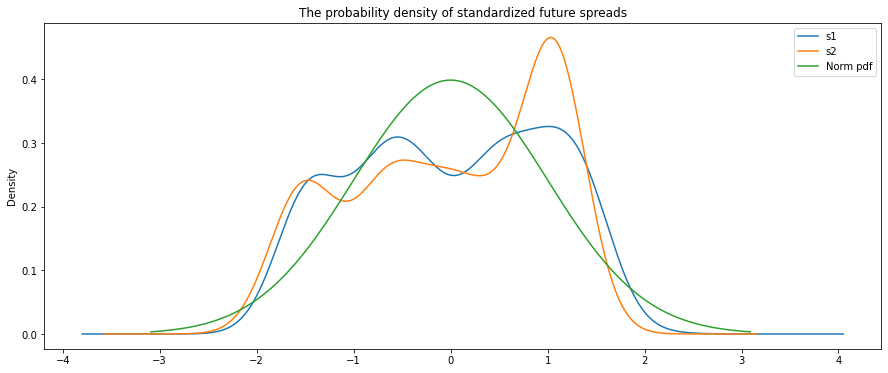

In [409]:
standardize_data(spreads).plot.kde()
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
plt.plot(x, norm.pdf(x),label='Norm pdf')
plt.legend()
plt.title('The probability density of standardized future spreads')
plt.show()

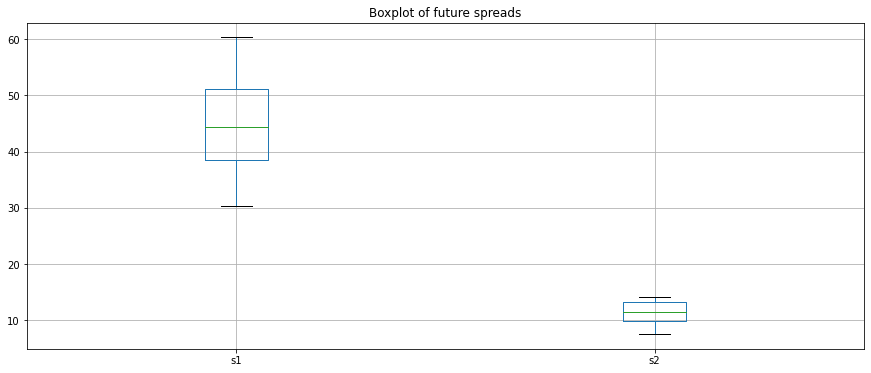

In [410]:
boxplot = spreads.boxplot()
plt.title('Boxplot of future spreads')
plt.show()

According to above charts and plots, s1 has higher average value and standard deviation. Also, based on the standardized data, all two spreads are negative skewed, and the plot of s1 is more symmetric since it has a skewness closer to 0. In addition, the kurtosis of the two spreads are lower than 3, so their tails are thinner and the peak is lower comparing with the normal distribution.

In [211]:
spreads.corr()

,s1,s2
s1,1.000000,0.976378
s2,0.976378,1.000000


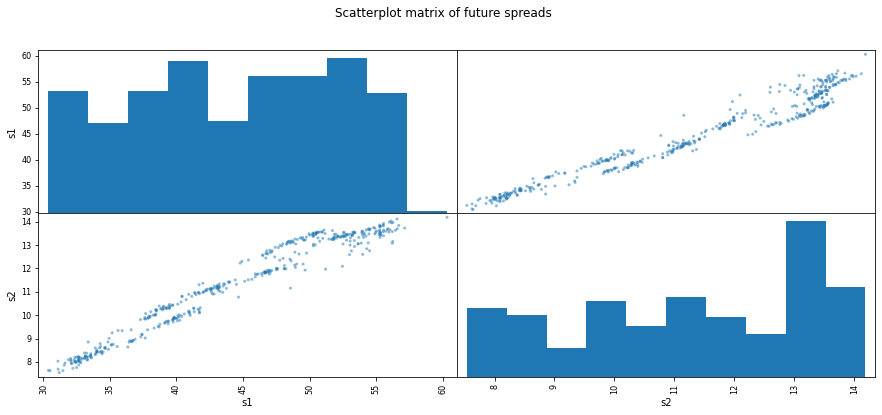

In [411]:
pd.plotting.scatter_matrix(spreads)
plt.suptitle('Scatterplot matrix of future spreads')
plt.show()

The correlation of two spreads is very close to 1, which indicates they have very high positive correlation.

### Autocorrelation

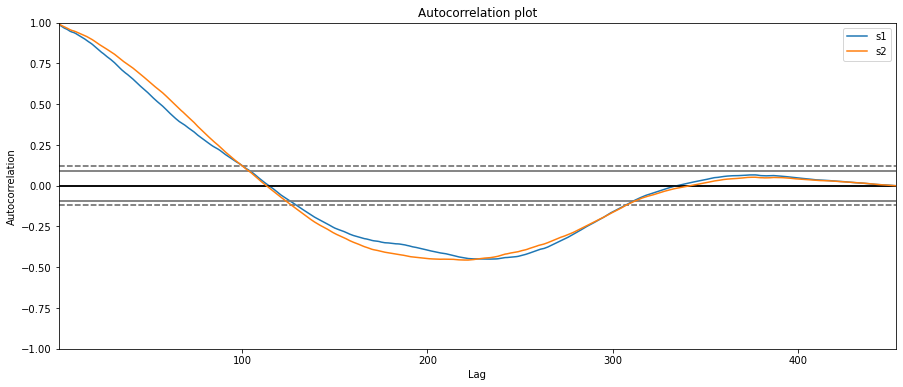

In [422]:
pd.plotting.autocorrelation_plot(s1, label='s1')
pd.plotting.autocorrelation_plot(s2, label='s2')
plt.title('Autocorrelation plot')
plt.show()

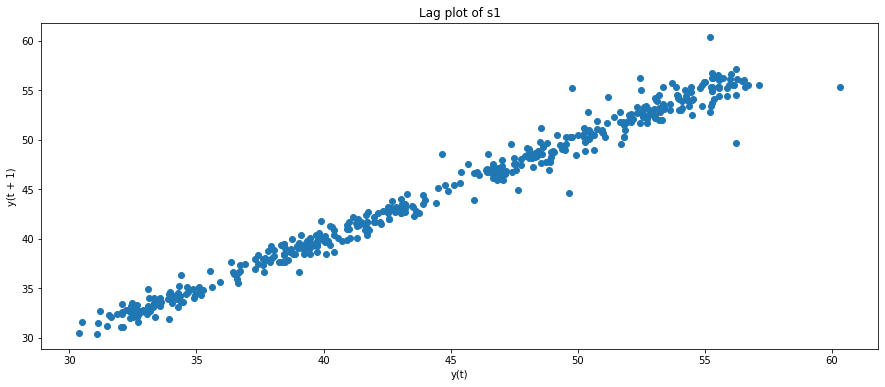

In [423]:
pd.plotting.lag_plot(s1, lag=1)
plt.title('Lag plot of s1')
plt.show()

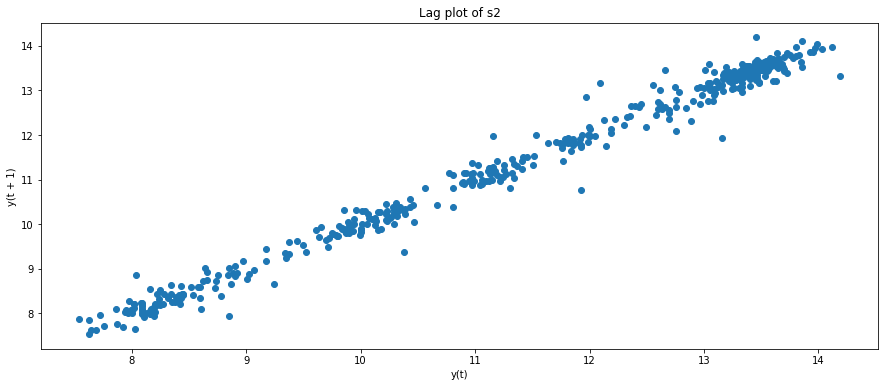

In [424]:
pd.plotting.lag_plot(s2, lag=1)
plt.title('Lag plot of s2')
plt.show()

According to the above plots, we can learn that both future spreads has very high auto correlation, which indicates the two spreads are strongly non-random. Values of the two spreads can be predicted based on preceding values. It further suggests that an autoregressive model might be appropriate.

### Time series decomposition

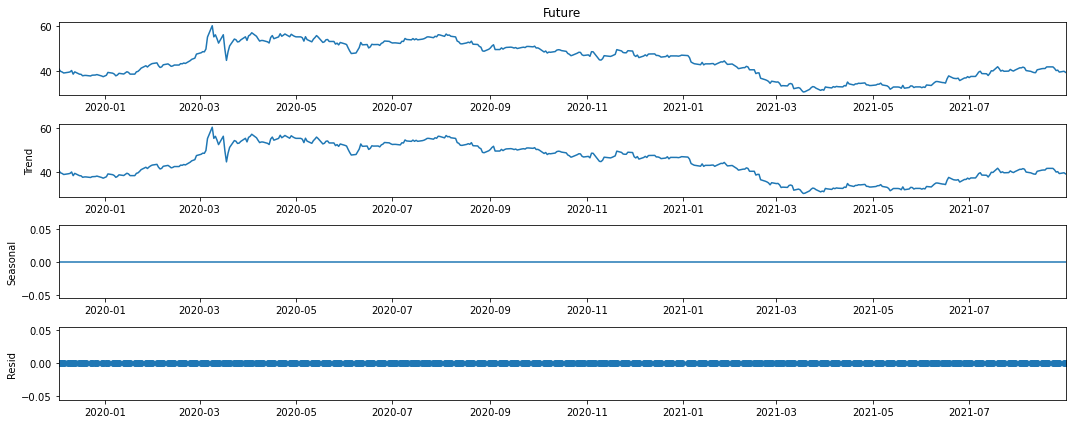

In [425]:
result = seasonal_decompose(s1, model='additive', period=1)
result.plot()
plt.show()

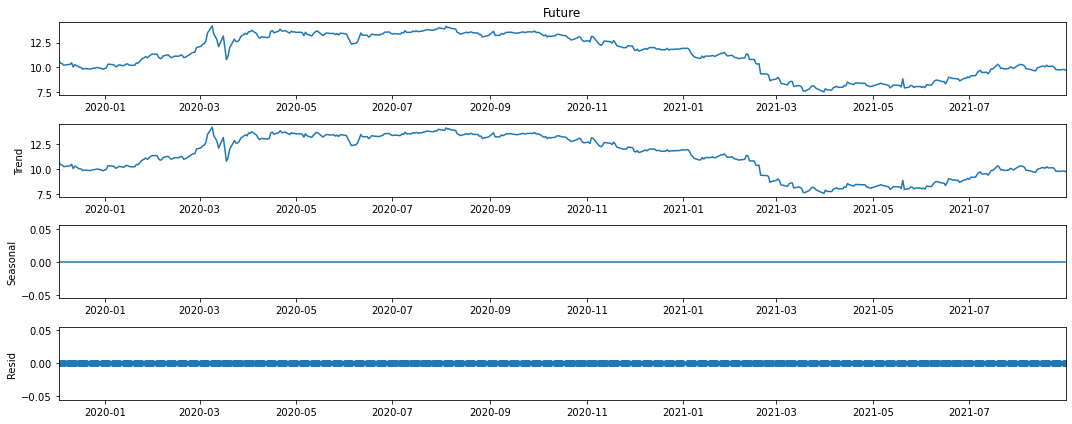

In [426]:
result = seasonal_decompose(s2, model='additive', period=1)
result.plot()
plt.show()

According to the above plots, both s1 and s2 has no seasonality. The entire series are taken as the trend component for both s1 and s2.

### Moving average of spreads

#### Calculate moving average

#### s1

In [467]:
d5_1 = s1 - s1.rolling(5).mean()
d20_1 = s1 - s1.rolling(20).mean()
d60_1 = s1 - s1.rolling(60).mean()

In [428]:
diff1 = pd.concat([d5_1, d20_1, d60_1], axis=1)
diff1.columns = ['5 Days', '20 Days', '60 Days']

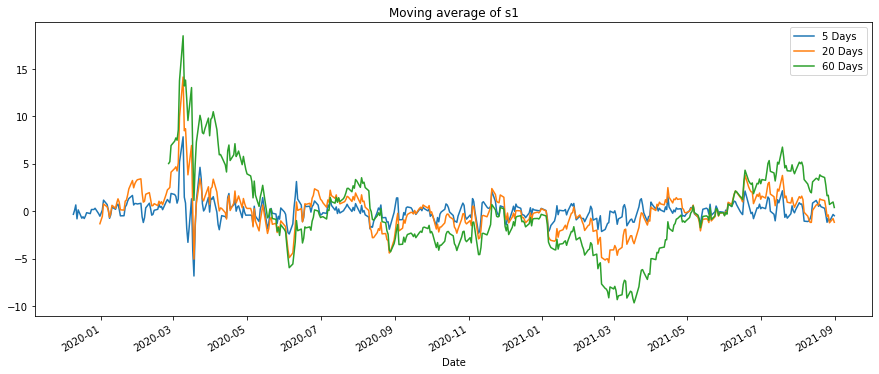

In [432]:
diff1.plot()
plt.title('Moving average of s1')
plt.show()

#### s2

In [433]:
d5_2 = s2 - s2.rolling(5).mean()
d20_2 = s2 - s2.rolling(20).mean()
d60_2 = s2 - s2.rolling(60).mean()

In [434]:
diff2 = pd.concat([d5_2, d20_2, d60_2], axis=1)
diff2.columns = ['5 Days', '20 Days', '60 Days']

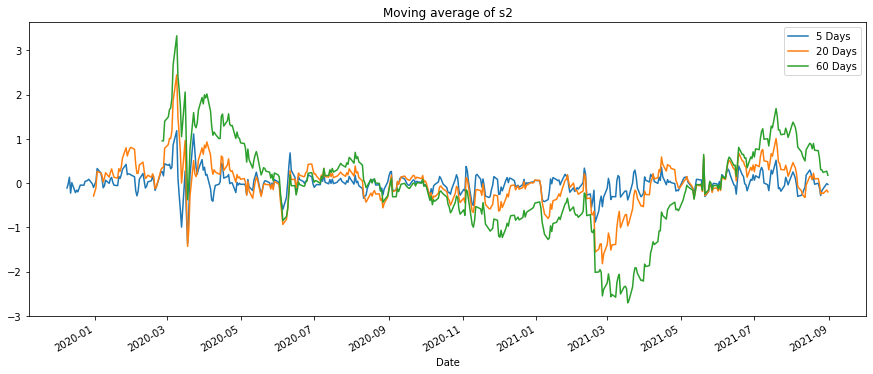

In [435]:
diff2.plot()
plt.title('Moving average of s2')
plt.show()

#### Basic statistics

#### s1

In [436]:
get_basic_statistics(diff1)

,5 Days,20 Days,60 Days
lower quartile,-0.532812,-1.165234,-2.793783
Median,0.039062,0.070312,-0.742188
upper quartile,0.542187,1.198340,2.811816
standard deviation,1.064794,2.118069,4.397609
skewness,0.516017,1.009600,0.591440
kurtosis,11.814007,6.216581,0.992870


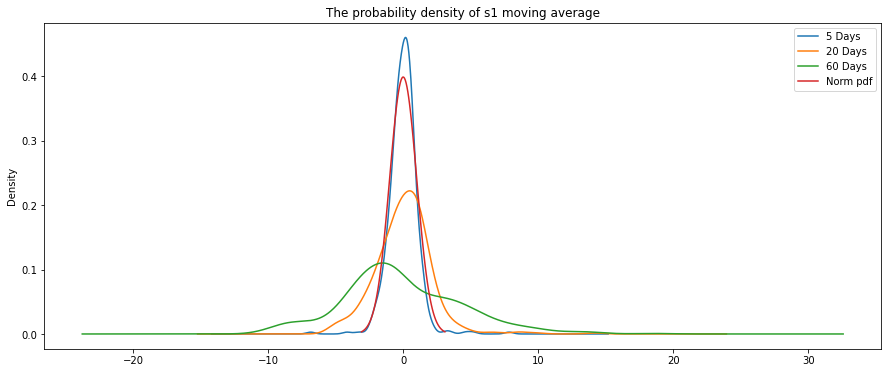

In [443]:
diff1.plot.kde()
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
plt.plot(x, norm.pdf(x),label='Norm pdf')
plt.legend()
plt.title('The probability density of s1 moving average')
plt.show()

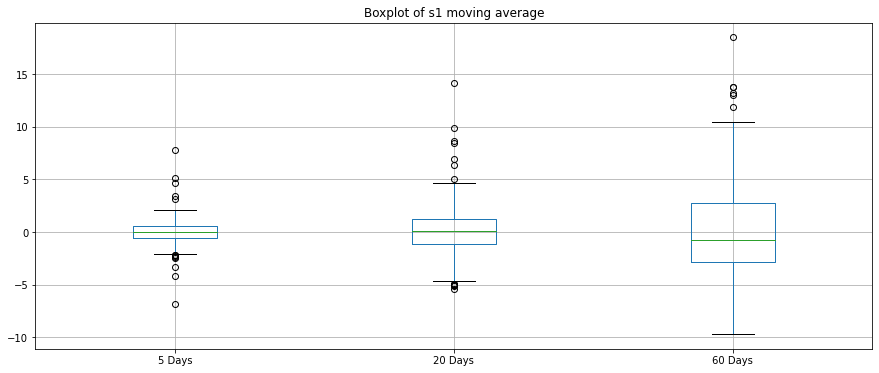

In [450]:
boxplot1 = diff1.boxplot()
plt.title('Boxplot of s1 moving average')
plt.show()

As the number of day increases, the standard deviation of difference between original spread and moving average (dn) increases, while the median decreases. The negative values for the skewness indicate data that are skewed left, so dn has a longer left tail comparing with the right tail. Both d5 and d20 has a kurtosis larger than 3, so they have "heavy-tailed" distributions. When N increases, the kurtosis decreases.

#### s2

In [451]:
get_basic_statistics(diff2)

,5 Days,20 Days,60 Days
lower quartile,-0.112500,-0.235547,-0.640983
Median,0.007812,0.043164,-0.052279
upper quartile,0.123437,0.247852,0.568815
standard deviation,0.236941,0.478550,1.012211
skewness,-0.189995,-0.219606,-0.194205
kurtosis,5.681860,3.315357,0.366778


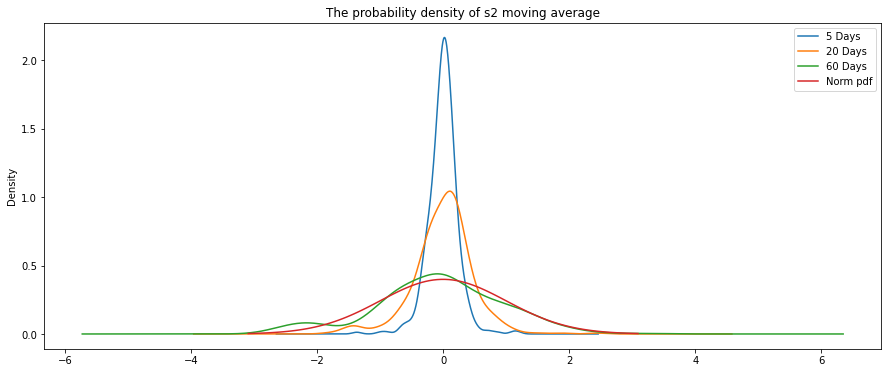

In [452]:
diff2.plot.kde()
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
plt.plot(x, norm.pdf(x),label='Norm pdf')
plt.legend()
plt.title('The probability density of s2 moving average')
plt.show()

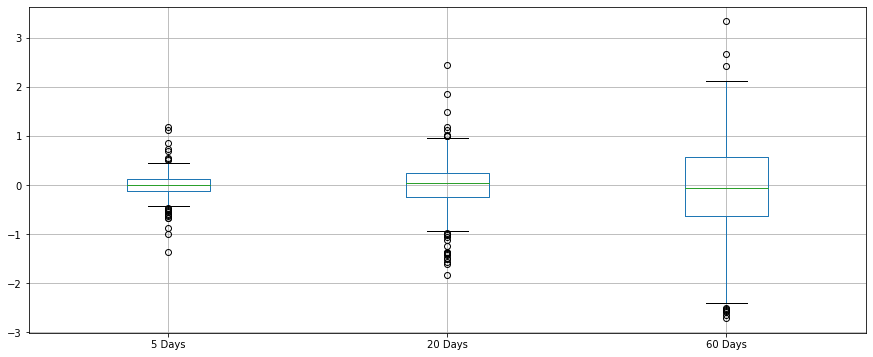

In [453]:
boxplot2 = diff2.boxplot(column=['5 Days', '20 Days', '60 Days'])

As the number of day increases, the standard deviation of dn increases and the median of dn decreases. d5, d20, d60 all have a longer left tail comparing with the right tail due to their negative skewness. d5 and d20 have a kurtosis larger than 3, so their distributions have heavy tail and flat peak. When the number of day increases, the kurtosis decreases, which indicates the distribution will have lighter tails.

### Remove Trend

#### s1

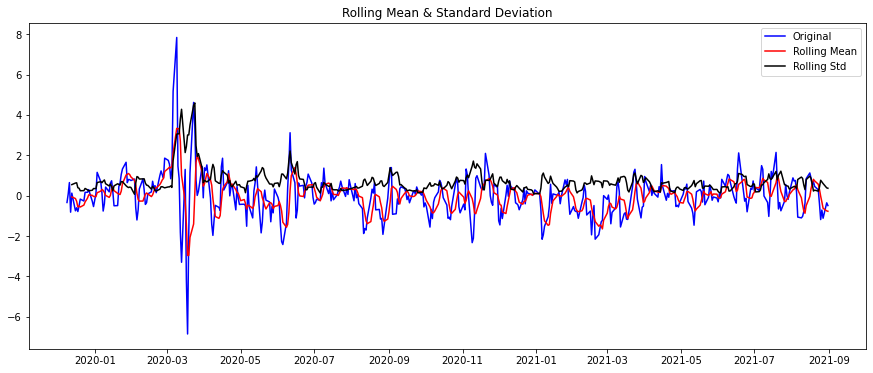

Results of Dickey-Fuller Test:
Test Statistic                  -5.206749
p-value                          0.000009
#Lags Used                      11.000000
Number of Observations Used    437.000000
Critical Value (1%)             -3.445403
Critical Value (5%)             -2.868177
Critical Value (10%)            -2.570305
dtype: float64


In [457]:
d5_1.dropna(inplace=True)
test_stationarity(d5_1)

#### s2

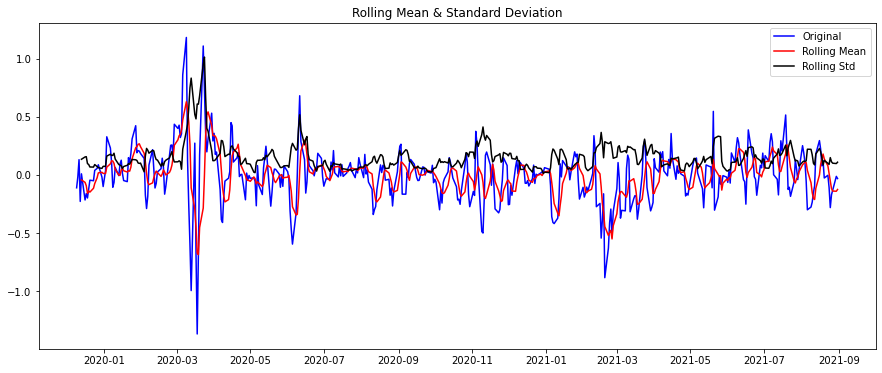

Results of Dickey-Fuller Test:
Test Statistic                -8.832168e+00
p-value                        1.757813e-14
#Lags Used                     5.000000e+00
Number of Observations Used    4.430000e+02
Critical Value (1%)           -3.445198e+00
Critical Value (5%)           -2.868086e+00
Critical Value (10%)          -2.570257e+00
dtype: float64


In [458]:
d5_2.dropna(inplace=True)
test_stationarity(d5_2)

I chose the 5-day moving average to remove trend. The results of Dickey-Fuller Test show the difference between spread and 5-day moving average apread (d5) is stationary for both s1 and s2.